# Transfer Learning Part 2: Fine-tuning 

## IMporting helper functions

Rewriting certain functions to monitor and evaluate our model can be tedious, so we can make our own script for some mundane activities

### Downloading hellper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
# IMporting from helper functions
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, walk_through_dir

## Let's get Some data

# Get 10% of our data and unzip it

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

In [3]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [4]:
# Create training and test directory paths
TRAIN_DIR = "10_food_classes_10_percent/train/"
TEST_DIR = "10_food_classes_10_percent/test/"

In [5]:
import tensorflow as tf

In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
LABEL_MODE = 'categorical'
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory= TRAIN_DIR, image_size= IMG_SIZE, label_mode= LABEL_MODE, batch_size= BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= TEST_DIR, image_size= IMG_SIZE, label_mode= LABEL_MODE, batch_size= BATCH_SIZE)

Found 750 files belonging to 10 classes.


2024-02-14 02:36:57.739668: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-02-14 02:36:57.739692: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-14 02:36:57.739699: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-14 02:36:57.739752: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-14 02:36:57.739784: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 2500 files belonging to 10 classes.


In [7]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
# Check out class names of our dataset
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an axample of batch of data
for images, labels in train_data.take(1):
    print(images, labels)

tf.Tensor(
[[[[2.53357147e+02 1.89000000e+02 6.70714264e+01]
   [2.51117340e+02 1.86045914e+02 6.03316307e+01]
   [2.51795914e+02 1.82214279e+02 5.44387741e+01]
   ...
   [1.78994476e+02 1.10147514e+02 1.55763044e+01]
   [1.39260117e+02 6.88570404e+01 2.63780642e+00]
   [1.18443344e+02 4.43872414e+01 4.22426081e+00]]

  [[2.53285721e+02 1.91285721e+02 6.90000000e+01]
   [2.52867355e+02 1.89000000e+02 6.48061218e+01]
   [2.52413269e+02 1.86586746e+02 5.88265305e+01]
   ...
   [1.67489456e+02 9.08312988e+01 1.59743767e+01]
   [1.30586609e+02 5.27243462e+01 3.80611372e+00]
   [1.08305695e+02 2.79026718e+01 8.26485157e-01]]

  [[2.52647964e+02 1.95290817e+02 6.98622437e+01]
   [2.51984695e+02 1.93301025e+02 6.72857132e+01]
   [2.52260193e+02 1.93428574e+02 6.49234695e+01]
   ...
   [1.34795624e+02 5.37955971e+01 1.01010108e+00]
   [1.08403030e+02 2.63315887e+01 0.00000000e+00]
   [1.10301041e+02 2.60204048e+01 2.58682728e+00]]

  ...

  [[0.00000000e+00 0.00000000e+00 2.00000000e+00]
   [0

## Model 0: Building a transfer learning model using Keras Functionsal API

The sequential API is straight-forwar, it runs our layers in sequential order.

But the functiosn API gives us more flexibility with our models

In [10]:
# 1. Create base model, with tf.keras.application

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top= False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into out model
inputs = tf.keras.layers.Input(shape= IMG_SIZE + (3, ), name= "input_layer")

# 4. If using a model like ResNEt50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average poo the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name= "global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling 2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation= 'softmax', name= 'output_layer')(x)


# 8. Combing the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss= tf.keras.losses.CategoricalCrossentropy(),
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['accuracy'])

# 10. Fit the model and save its hsitory
history_0 = model_0.fit(train_data,
                        epochs= 5,
                        steps_per_epoch= len(train_data),
                        validation_data= test_data,
                        validation_steps= len(test_data),
                        callbacks= [create_tensorboard_callback(
                            dir_name= "tensorflow_hub", experiment_name= 'model_0')]) 

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after Global Average Pooling 2D: (None, 1280)
Saving TensorBoard log files to: tensorflow_hub/model_0/20240214-023700
Epoch 1/5


2024-02-14 02:37:02.437614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-02-14 02:37:02.570082: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


24/24 [==============================] - 16s 405ms/step - loss: 1.9687 - accuracy: 0.3587 - val_loss: 1.4087 - val_accuracy: 0.6848
Epoch 2/5
24/24 [==============================] - 6s 234ms/step - loss: 1.2477 - accuracy: 0.7027 - val_loss: 0.9648 - val_accuracy: 0.7940
Epoch 3/5
24/24 [==============================] - 5s 227ms/step - loss: 0.9424 - accuracy: 0.7880 - val_loss: 0.7683 - val_accuracy: 0.8296
Epoch 4/5
24/24 [==============================] - 5s 231ms/step - loss: 0.7539 - accuracy: 0.8400 - val_loss: 0.6582 - val_accuracy: 0.8500
Epoch 5/5
24/24 [==============================] - 5s 231ms/step - loss: 0.6688 - accuracy: 0.8507 - val_loss: 0.5955 - val_accuracy: 0.8560


In [11]:
# Evaluate
model_0.evaluate(test_data)

79/79 [==============================] - 4s 54ms/step - loss: 0.5955 - accuracy: 0.8560


[0.595467746257782, 0.8560000061988831]

In [12]:
# Check the layers in our base model
for layer_num, layer in enumerate(base_model.layers):
    print(layer_num, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [13]:
# how about we get the summary of the base model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [14]:
# how about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

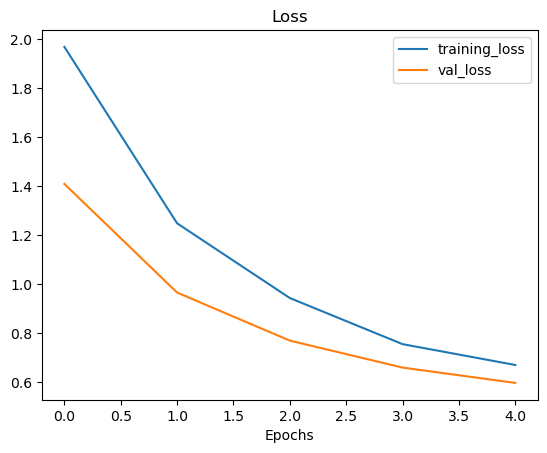

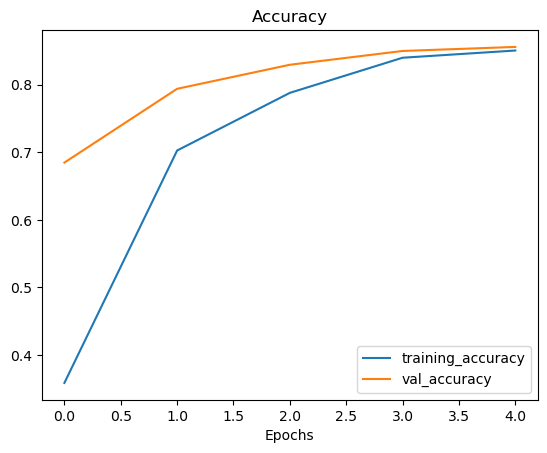

In [15]:
plot_loss_curves(history_0)

## Getting feature vector form trained model

Let's demonstrate GlobalAveragePooling2D layer

We have a tensor after our modle goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it through GlobalAveragePooling2D.

In [16]:
# Define input shape
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tesnor: \n {input_tensor} \n")

# Passing the random tensor trhough a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: \n {global_average_pooled_tensor} \n")

#Check the shape of the different tensord
print(f"Shape of input tensord: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensord: {global_average_pooled_tensor.shape}")

Random input tesnor: 
 [[[[ 0.3274686  -0.8426257   0.3194336 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.5397071   1.6994324 ]
   [ 0.28893656 -1.5066117  -0.26454768]]

  [[-0.5972242  -1.9171131  -0.6204413 ]
   [ 0.8504024  -0.4060477  -3.0258412 ]
   [ 0.9058465   0.29855984 -0.22561562]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772706]
   [ 0.24694408  0.20573746 -0.5256234 ]
   [ 0.32410023  0.02545409 -0.10638493]
   [-0.6369476   1.1603122   0.25073594]]

  [[-0.41728497  0.40125772 -1.4145442 ]
   [-0.5931858  -1.6617215   0.3356716 ]
   [ 0.1081563   0.23479682 -0.56668764]
   [-0.35819843  0.8869861   0.5274477 ]]]] 

2D global average pooled random tensor: 
 [[-0.09368647 -0.45840445 -0.28855982]] 

Shape of input tensord: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensord: (1, 3)


In [17]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis= [1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368647, -0.45840445, -0.28855982]], dtype=float32)>

> **Practice**: Try to do the same withthe above two cells but this time use `GlobalMaxPool2D` ... and see what happens

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training dat, but how does it go with 1% of the training data... how about we set up a bunmch of experiments to find out:

1. `model_1` use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2`: use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3`: use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4`: use fine-tuning transfer learning on 100% of the training data with data augmentation


> **Note**: throughout all the experiments the same test dataset will be used to evaluate our model... thsi ensures consistency across evaluation metrics

## Getting and preprocessing our data for model_1

# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

In [18]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'

In [19]:
# Creating training and test dir
TRAIN_DIR_1 = "10_food_classes_1_percent/train/"
TEST_DIR_1 = "10_food_classes_1_percent/test/"

In [20]:
# Setup data loaders

train_data_1 = tf.keras.preprocessing.image_dataset_from_directory(directory= TRAIN_DIR_1, label_mode= LABEL_MODE, batch_size= BATCH_SIZE, image_size= IMG_SIZE)

test_data_1 = tf.keras.preprocessing.image_dataset_from_directory(directory= TEST_DIR_1, label_mode= LABEL_MODE, batch_size= BATCH_SIZE, image_size= IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into out model, we can us the layers inside:

* tf.keras.layers.experimental.preprocessing()

We can see the benefits of doing this in the documentations of data augmentatioon inside the model

* Preprocessing of the images happens in GPU
* The preprocessing layers are also saved when the model is being saved to use as an idependent application

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

In [28]:
# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # layers.Rescaling(1./255) # Keep for models like ResNet50 but EfficientNet already has the layer in built
], name= "data_augmentation")

(-0.5, 383.5, 511.5, -0.5)

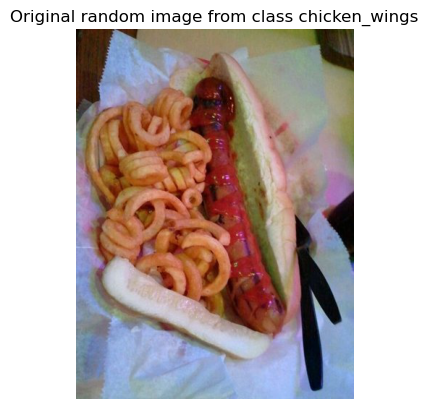

In [24]:
# View a random iamge and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

### Visualise or data augmentation layer

2024-02-14 02:47:35.642438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


(-0.5, 487.5, 478.5, -0.5)

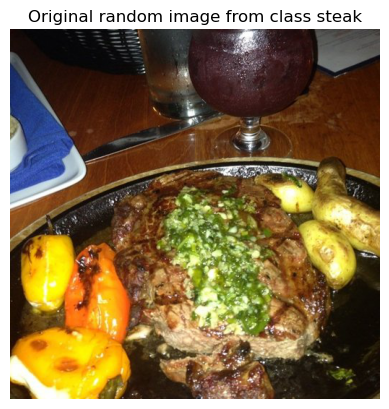

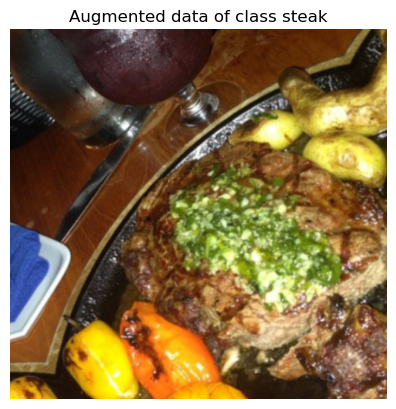

In [29]:
# View a random iamge and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augmented random image

augmented_img = data_augmentation(tf.expand_dims(img, axis= 0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented data of class {target_class}")
plt.axis(False)

## Model 1: Feature Extraction transfer learning on 1% of the data with data augmentation

In [36]:
# Setup the input shape and base model, freezing the base model layers

input_shape = IMG_SIZE + (3, )
base_model = tf.keras.applications.EfficientNetB0(include_top= False)

base_model.trainable = False

# Create input layer
inputs = layers.Input(shape= input_shape, name= 'input_layer')

#Add in data augmentation Sequential model as layer
x = data_augmentation(inputs)

# Give base_model the inputs and don't train it
x = base_model(x, training= False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation= 'softmax', name= 'output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

model_1.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.legacy.Adam(),
                metrics= ['accuracy'])

In [37]:
history_1_percent = model_1.fit(train_data_1, 
            epochs= 5,
            steps_per_epoch= len(train_data_1),
            validation_data= test_data_1,
            validation_steps= len(test_data_1),
            callbacks= [create_tensorboard_callback("tensorflow_hub", "1_percent_data_aug")])

Saving TensorBoard log files to: tensorflow_hub/1_percent_data_aug/20240214-025954
Epoch 1/5


2024-02-14 02:59:56.502877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/3 [=========>....................] - ETA: 9s - loss: 2.4113 - accuracy: 0.1875

2024-02-14 02:59:59.229535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/3 [===================>..........] - ETA: 1s - loss: 2.3879 - accuracy: 0.1250

2024-02-14 03:00:00.854939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/3 [==============================] - 17s 6s/step - loss: 2.3806 - accuracy: 0.1143 - val_loss: 2.2626 - val_accuracy: 0.1644
Epoch 2/5


2024-02-14 03:00:11.505587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/3 [=========>....................] - ETA: 2s - loss: 2.2355 - accuracy: 0.1250

2024-02-14 03:00:12.853996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/3 [===================>..........] - ETA: 1s - loss: 2.1636 - accuracy: 0.1562

2024-02-14 03:00:14.187792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/3 [==============================] - 11s 5s/step - loss: 2.1359 - accuracy: 0.1571 - val_loss: 2.1314 - val_accuracy: 0.2424
Epoch 3/5


2024-02-14 03:00:22.531357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/3 [=========>....................] - ETA: 2s - loss: 1.9628 - accuracy: 0.3750

2024-02-14 03:00:23.854659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/3 [===================>..........] - ETA: 1s - loss: 1.9560 - accuracy: 0.3281

2024-02-14 03:00:25.185205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/3 [==============================] - 10s 4s/step - loss: 1.9676 - accuracy: 0.3286 - val_loss: 2.0187 - val_accuracy: 0.3100
Epoch 4/5


2024-02-14 03:00:32.782790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/3 [=========>....................] - ETA: 1s - loss: 1.8412 - accuracy: 0.5000

2024-02-14 03:00:33.543251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/3 [===================>..........] - ETA: 1s - loss: 1.7612 - accuracy: 0.5312

2024-02-14 03:00:34.834967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/3 [==============================] - 10s 4s/step - loss: 1.7538 - accuracy: 0.5286 - val_loss: 1.9173 - val_accuracy: 0.3752
Epoch 5/5


2024-02-14 03:00:42.325312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/3 [=========>....................] - ETA: 2s - loss: 1.7229 - accuracy: 0.5312

2024-02-14 03:00:43.441072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/3 [===================>..........] - ETA: 1s - loss: 1.6072 - accuracy: 0.6719

2024-02-14 03:00:44.884333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/3 [==============================] - 10s 4s/step - loss: 1.6136 - accuracy: 0.6714 - val_loss: 1.8275 - val_accuracy: 0.4348


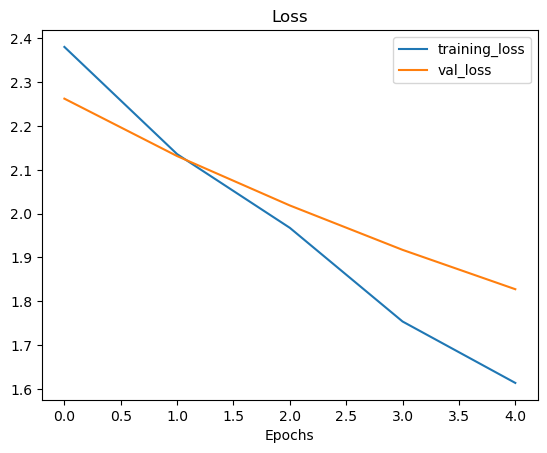

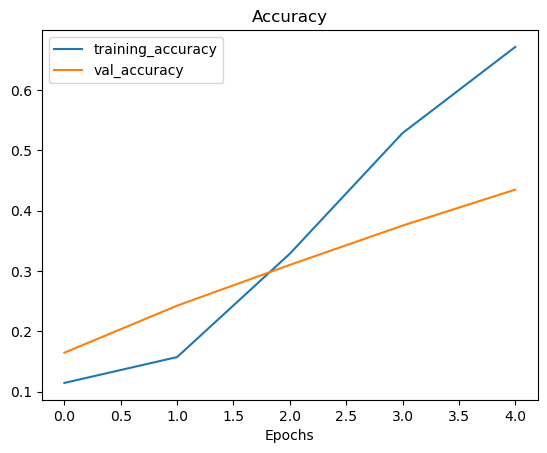

In [38]:
plot_loss_curves(history_1_percent)

In [39]:
# Check out model summary
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [41]:
# Evaluate
model_1.evaluate(test_data_1)

79/79 [==============================] - 7s 76ms/step - loss: 1.8275 - accuracy: 0.4348


[1.8275229930877686, 0.43479999899864197]

## Model 2: feature extraction transfer learning model with 10% data and data augmentation

In [43]:
# Get 10 % of our data
train_dir_10 = "10_food_classes_10_percent/train"
test_dir_10 = "10_food_classes_10_percent/test"

In [45]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [44]:
train_data_10 = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10, label_mode= LABEL_MODE, image_size= IMG_SIZE)

test_data_10 = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10, label_mode= LABEL_MODE, image_size= IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [46]:
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, None, None, 3)     0         
                                                                 
 random_rotation (RandomRot  (None, None, None, 3)     0         
 ation)                                                          
                                                                 
 random_zoom_1 (RandomZoom)  (None, None, None, 3)     0         
                                                                 
 random_height (RandomHeigh  (None, None, None, 3)     0         
 t)                                                              
                                                                 
 random_width (RandomWidth)  (None, None, None, 3)     0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (

In [61]:
# Create model 2 with data augmentation built in
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2)
], name= 'data_augmentation')

# Setup the input shape
input_shape = IMG_SIZE + (3, )

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Create the inputs and outputs
inputs = layers.Input(shape= input_shape, name= 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training= False)
x = layers.GlobalAveragePooling2D(name= 'global_average_poolonmg_2D')(x)
outputs = layers.Dense(10, activation= 'softmax', name= 'output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.legacy.Adam(),
                metrics= ['accuracy'])

In [55]:
model_2.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_poolonmg_2D  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback immediately saves our model so that we can start where left. 

In [62]:
# Set checkpoint path
checkpoint_path = 'model_checkpoints/weights/checkpoint.ckpt'

# Create a ModelCheckpoint callback that saves models weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path, save_weights_only= True, save_best_only= False, save_freq= 'epoch', verbose= 1)

In [63]:
history_10_percent = model_2.fit(train_data_10,
            epochs= 5,
            steps_per_epoch= len(train_data_10),
            validation_data= test_data_10,
            validation_steps= len(test_data_10),
            callbacks= [create_tensorboard_callback('tensorflow_hub', "10_percent_data_aug"),
                        checkpoint_callback])

Saving TensorBoard log files to: tensorflow_hub/10_percent_data_aug/20240214-034943
Epoch 1/5


2024-02-14 03:49:45.543647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 2:26 - loss: 2.4065 - accuracy: 0.0938

2024-02-14 03:49:49.877775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 38s - loss: 2.3815 - accuracy: 0.1250 

2024-02-14 03:49:51.545908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 31s - loss: 2.3842 - accuracy: 0.1146

2024-02-14 03:49:52.806709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 32s - loss: 2.3533 - accuracy: 0.1328

2024-02-14 03:49:54.656095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 36s - loss: 2.3440 - accuracy: 0.1312

2024-02-14 03:49:57.485661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 33s - loss: 2.3439 - accuracy: 0.1354

2024-02-14 03:49:59.216549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 33s - loss: 2.2879 - accuracy: 0.1786

2024-02-14 03:50:01.485958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 31s - loss: 2.2628 - accuracy: 0.1875

2024-02-14 03:50:03.360435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 28s - loss: 2.2520 - accuracy: 0.1910

2024-02-14 03:50:04.803773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 26s - loss: 2.2328 - accuracy: 0.2031

2024-02-14 03:50:06.598718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 23s - loss: 2.2147 - accuracy: 0.2102

2024-02-14 03:50:08.256503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 22s - loss: 2.1970 - accuracy: 0.2161

2024-02-14 03:50:10.336671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 20s - loss: 2.1778 - accuracy: 0.2188

2024-02-14 03:50:11.941024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 18s - loss: 2.1539 - accuracy: 0.2321

2024-02-14 03:50:14.151941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 16s - loss: 2.1303 - accuracy: 0.2479

2024-02-14 03:50:16.076822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 14s - loss: 2.1110 - accuracy: 0.2578

2024-02-14 03:50:17.754678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 13s - loss: 2.0907 - accuracy: 0.2702

2024-02-14 03:50:19.519014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 10s - loss: 2.0735 - accuracy: 0.2795

2024-02-14 03:50:20.878807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 8s - loss: 2.0660 - accuracy: 0.2829 

2024-02-14 03:50:21.985809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 7s - loss: 2.0502 - accuracy: 0.2937

2024-02-14 03:50:23.573009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 5s - loss: 2.0305 - accuracy: 0.3065

2024-02-14 03:50:25.127503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 3s - loss: 2.0121 - accuracy: 0.3182

2024-02-14 03:50:26.710798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 1s - loss: 1.9975 - accuracy: 0.3261

2024-02-14 03:50:28.257335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - ETA: 0s - loss: 1.9944 - accuracy: 0.3307
Epoch 1: saving model to model_checkpoints/weights/checkpoint.ckpt
24/24 [==============================] - 71s 3s/step - loss: 1.9944 - accuracy: 0.3307 - val_loss: 1.4547 - val_accuracy: 0.6808
Epoch 2/5


2024-02-14 03:50:54.227419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 46s - loss: 1.4190 - accuracy: 0.7188

2024-02-14 03:50:56.247425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 1:03 - loss: 1.4669 - accuracy: 0.6875

2024-02-14 03:50:59.148214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 40s - loss: 1.3942 - accuracy: 0.7083 

2024-02-14 03:51:00.119828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 36s - loss: 1.4053 - accuracy: 0.6875

2024-02-14 03:51:01.686006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 33s - loss: 1.4235 - accuracy: 0.6812

2024-02-14 03:51:03.355211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 31s - loss: 1.4235 - accuracy: 0.6771

2024-02-14 03:51:05.128862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 29s - loss: 1.4148 - accuracy: 0.6652

2024-02-14 03:51:06.668953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 26s - loss: 1.3994 - accuracy: 0.6641

2024-02-14 03:51:07.907406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 26s - loss: 1.4076 - accuracy: 0.6597

2024-02-14 03:51:10.441247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 24s - loss: 1.4158 - accuracy: 0.6469

2024-02-14 03:51:12.033942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 23s - loss: 1.4266 - accuracy: 0.6420

2024-02-14 03:51:14.335362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 21s - loss: 1.4161 - accuracy: 0.6458

2024-02-14 03:51:16.370729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 20s - loss: 1.4120 - accuracy: 0.6466

2024-02-14 03:51:18.929753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 18s - loss: 1.4007 - accuracy: 0.6496

2024-02-14 03:51:20.613602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 16s - loss: 1.3870 - accuracy: 0.6542

2024-02-14 03:51:21.865219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 15s - loss: 1.3665 - accuracy: 0.6660

2024-02-14 03:51:24.392194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 13s - loss: 1.3524 - accuracy: 0.6765

2024-02-14 03:51:27.413665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 11s - loss: 1.3494 - accuracy: 0.6753

2024-02-14 03:51:28.559943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 9s - loss: 1.3408 - accuracy: 0.6826 

2024-02-14 03:51:29.994684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 7s - loss: 1.3354 - accuracy: 0.6828

2024-02-14 03:51:31.998090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 5s - loss: 1.3314 - accuracy: 0.6815

2024-02-14 03:51:33.237217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 3s - loss: 1.3188 - accuracy: 0.6875

2024-02-14 03:51:35.187242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 1s - loss: 1.3108 - accuracy: 0.6861

2024-02-14 03:51:36.792711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - ETA: 0s - loss: 1.3003 - accuracy: 0.6907
Epoch 2: saving model to model_checkpoints/weights/checkpoint.ckpt
24/24 [==============================] - 70s 3s/step - loss: 1.3003 - accuracy: 0.6907 - val_loss: 1.0090 - val_accuracy: 0.7824
Epoch 3/5


2024-02-14 03:52:04.554796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 40s - loss: 1.2514 - accuracy: 0.6562

2024-02-14 03:52:06.351924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 27s - loss: 1.1770 - accuracy: 0.6875

2024-02-14 03:52:07.586801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 30s - loss: 1.2317 - accuracy: 0.6667

2024-02-14 03:52:09.254035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 32s - loss: 1.2024 - accuracy: 0.6797

2024-02-14 03:52:11.269466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 30s - loss: 1.1723 - accuracy: 0.7000

2024-02-14 03:52:12.697700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 28s - loss: 1.1116 - accuracy: 0.7240

2024-02-14 03:52:14.125428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 28s - loss: 1.1414 - accuracy: 0.7054

2024-02-14 03:52:16.224186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 26s - loss: 1.1280 - accuracy: 0.7148

2024-02-14 03:52:17.792233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 25s - loss: 1.1200 - accuracy: 0.7222

2024-02-14 03:52:19.857839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 23s - loss: 1.1198 - accuracy: 0.7156

2024-02-14 03:52:21.558631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 22s - loss: 1.0883 - accuracy: 0.7301

2024-02-14 03:52:23.683683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 21s - loss: 1.0921 - accuracy: 0.7292

2024-02-14 03:52:26.493395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 20s - loss: 1.0814 - accuracy: 0.7356

2024-02-14 03:52:28.862941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 18s - loss: 1.0756 - accuracy: 0.7344

2024-02-14 03:52:30.425562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 16s - loss: 1.0666 - accuracy: 0.7375

2024-02-14 03:52:31.991456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 14s - loss: 1.0671 - accuracy: 0.7383

2024-02-14 03:52:33.987609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 12s - loss: 1.0528 - accuracy: 0.7426

2024-02-14 03:52:35.986803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 10s - loss: 1.0529 - accuracy: 0.7361

2024-02-14 03:52:37.194774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 9s - loss: 1.0387 - accuracy: 0.7434 

2024-02-14 03:52:39.151305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 7s - loss: 1.0313 - accuracy: 0.7484

2024-02-14 03:52:40.285683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 5s - loss: 1.0423 - accuracy: 0.7426

2024-02-14 03:52:42.191003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 3s - loss: 1.0385 - accuracy: 0.7443

2024-02-14 03:52:43.321931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 1s - loss: 1.0195 - accuracy: 0.7527

2024-02-14 03:52:45.832010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - ETA: 0s - loss: 1.0156 - accuracy: 0.7547
Epoch 3: saving model to model_checkpoints/weights/checkpoint.ckpt
24/24 [==============================] - 81s 3s/step - loss: 1.0156 - accuracy: 0.7547 - val_loss: 0.8082 - val_accuracy: 0.8084
Epoch 4/5


2024-02-14 03:53:26.052143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 1:00 - loss: 0.8142 - accuracy: 0.8750

2024-02-14 03:53:28.672602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 40s - loss: 0.7677 - accuracy: 0.8594 

2024-02-14 03:53:30.525274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 36s - loss: 0.7571 - accuracy: 0.8542

2024-02-14 03:53:32.161816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 35s - loss: 0.7942 - accuracy: 0.8516

2024-02-14 03:53:33.927193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 36s - loss: 0.7914 - accuracy: 0.8375

2024-02-14 03:53:36.274607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 33s - loss: 0.8189 - accuracy: 0.8333

2024-02-14 03:53:38.116591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 30s - loss: 0.8312 - accuracy: 0.8259

2024-02-14 03:53:39.538403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 28s - loss: 0.8479 - accuracy: 0.8086

2024-02-14 03:53:41.288620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 26s - loss: 0.8175 - accuracy: 0.8229

2024-02-14 03:53:42.916015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 25s - loss: 0.8456 - accuracy: 0.8094

2024-02-14 03:53:44.846471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 22s - loss: 0.8439 - accuracy: 0.8097

2024-02-14 03:53:46.185242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 20s - loss: 0.8612 - accuracy: 0.7969

2024-02-14 03:53:47.902207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 19s - loss: 0.8755 - accuracy: 0.7909

2024-02-14 03:53:49.493743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 18s - loss: 0.8766 - accuracy: 0.7879

2024-02-14 03:53:52.262113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 16s - loss: 0.8618 - accuracy: 0.7937

2024-02-14 03:53:54.331855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 14s - loss: 0.8507 - accuracy: 0.8008

2024-02-14 03:53:55.737758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 12s - loss: 0.8490 - accuracy: 0.7978

2024-02-14 03:53:57.559625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 10s - loss: 0.8418 - accuracy: 0.7969

2024-02-14 03:53:59.428021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 9s - loss: 0.8444 - accuracy: 0.7928 

2024-02-14 03:54:01.233052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 7s - loss: 0.8566 - accuracy: 0.7859

2024-02-14 03:54:03.017067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 5s - loss: 0.8580 - accuracy: 0.7798

2024-02-14 03:54:05.421954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 3s - loss: 0.8518 - accuracy: 0.7812

2024-02-14 03:54:07.119034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 1s - loss: 0.8466 - accuracy: 0.7840

2024-02-14 03:54:08.814622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - ETA: 0s - loss: 0.8488 - accuracy: 0.7813
Epoch 4: saving model to model_checkpoints/weights/checkpoint.ckpt
24/24 [==============================] - 84s 4s/step - loss: 0.8488 - accuracy: 0.7813 - val_loss: 0.6945 - val_accuracy: 0.8348
Epoch 5/5


2024-02-14 03:54:50.419772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 44s - loss: 0.6410 - accuracy: 0.8750

2024-02-14 03:54:52.357986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 42s - loss: 0.6798 - accuracy: 0.8438

2024-02-14 03:54:54.288360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 45s - loss: 0.6499 - accuracy: 0.8542

2024-02-14 03:54:56.691847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 41s - loss: 0.6591 - accuracy: 0.8438

2024-02-14 03:54:58.656694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 38s - loss: 0.6211 - accuracy: 0.8625

2024-02-14 03:55:00.542625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 34s - loss: 0.6570 - accuracy: 0.8385

2024-02-14 03:55:02.032366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 34s - loss: 0.6750 - accuracy: 0.8304

2024-02-14 03:55:04.616135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 33s - loss: 0.6544 - accuracy: 0.8398

2024-02-14 03:55:06.810539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 32s - loss: 0.6659 - accuracy: 0.8333

2024-02-14 03:55:09.736910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 30s - loss: 0.6714 - accuracy: 0.8344

2024-02-14 03:55:11.769240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 26s - loss: 0.6757 - accuracy: 0.8324

2024-02-14 03:55:12.922882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 24s - loss: 0.6915 - accuracy: 0.8307

2024-02-14 03:55:14.600386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 22s - loss: 0.7187 - accuracy: 0.8173

2024-02-14 03:55:16.490402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 19s - loss: 0.7149 - accuracy: 0.8192

2024-02-14 03:55:18.162746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 18s - loss: 0.7066 - accuracy: 0.8229

2024-02-14 03:55:20.929122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 15s - loss: 0.7165 - accuracy: 0.8125

2024-02-14 03:55:22.257916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 13s - loss: 0.7172 - accuracy: 0.8143

2024-02-14 03:55:23.897775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 11s - loss: 0.7264 - accuracy: 0.8073

2024-02-14 03:55:25.302875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 9s - loss: 0.7154 - accuracy: 0.8092 

2024-02-14 03:55:27.186418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 7s - loss: 0.7210 - accuracy: 0.8094

2024-02-14 03:55:29.486722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 5s - loss: 0.7321 - accuracy: 0.8006

2024-02-14 03:55:31.023334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 3s - loss: 0.7308 - accuracy: 0.7997

2024-02-14 03:55:34.210880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 1s - loss: 0.7420 - accuracy: 0.7948

2024-02-14 03:55:35.870171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - ETA: 0s - loss: 0.7352 - accuracy: 0.7987
Epoch 5: saving model to model_checkpoints/weights/checkpoint.ckpt
24/24 [==============================] - 87s 4s/step - loss: 0.7352 - accuracy: 0.7987 - val_loss: 0.6330 - val_accuracy: 0.8412


In [64]:
model_0.evaluate(test_data)

79/79 [==============================] - 56s 661ms/step - loss: 0.5955 - accuracy: 0.8560


[0.595467746257782, 0.8560000061988831]

In [65]:
model_2.evaluate(test_data_10)

79/79 [==============================] - 45s 559ms/step - loss: 0.6330 - accuracy: 0.8412


[0.6329760551452637, 0.8411999940872192]

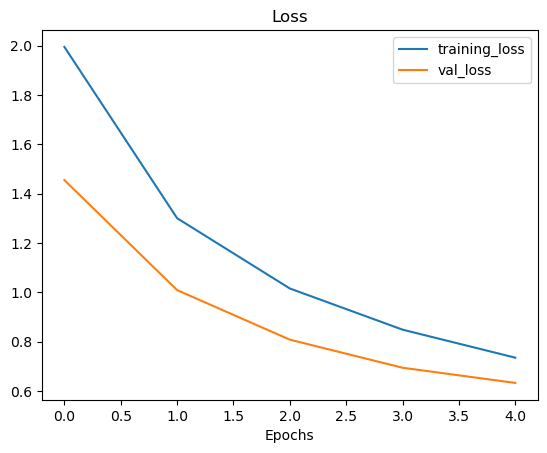

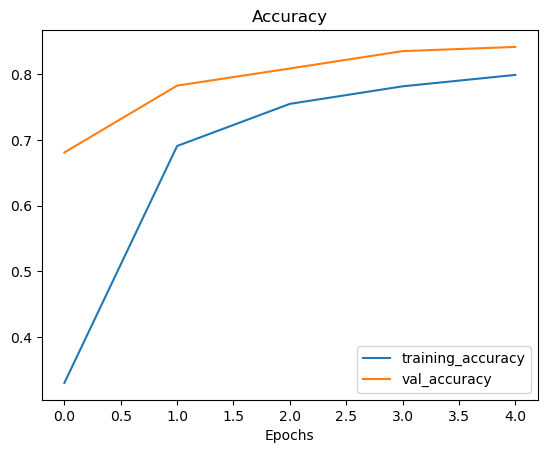

In [66]:
plot_loss_curves(history_10_percent)

### Loading in checkpointed weights

Loading in checkpoint weights returns a model to a specific checkpoint

In [67]:
# Load in saved models weights and evaluate model 
model_2.load_weights(checkpoint_path)

In [68]:
# Evaluate model_2 with loaded weights
model_2.evaluate(test_data_10)

79/79 [==============================] - 49s 618ms/step - loss: 0.6330 - accuracy: 0.8412


[0.6329760551452637, 0.8411999940872192]

In [ ]:
# Check to see if loaded model results are very close to our previous non-loaded model results

# import numpy as np
# np.isclose()